# Exploring my Personal Physiological, Sleep, Workout, and Journal Data from WHOOP Exports
### Pat Geitner

The goal of this notebook is two-fold:
1. Create a pipeline for combining the different datasets (physiological, sleep, workout, and journal) from a WHOOP export into a format where I can easily complete other analysis like evaluating the impact of certain behaviors on sleep and recovery
2. Replicate strain and recovery scoring algorithms with simple supervised machine learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

Reading in the 4 datasets and printing their sizes

In [2]:
phys_df = pd.read_csv('./export_12_2022/physiological_cycles.csv')
sleep_df = pd.read_csv('./export_12_2022/sleeps.csv')
wkt_df = pd.read_csv('./export_12_2022/workouts.csv')
jrn_df = pd.read_csv('./export_12_2022/journal_entries.csv')

print(f'Physiological cycles: {phys_df.shape}\nSleeps: {sleep_df.shape}\nWorkouts: {wkt_df.shape}\nJournal entries: {jrn_df.shape}')

FileNotFoundError: [Errno 2] No such file or directory: './export_12_2022/physiological_cycles.csv'

Pre-Processing all datetime columns

In [ ]:
def process_date_col(df, col_names=[['Cycle start time', 'Cycle end time']]):
    for col in col_names:
        nme = col[0].split(' ')[0]
        df[col] = df[col].astype('datetime64[ns]')

        if nme == 'Cycle':
            df['date'] = df[col[0]].astype('datetime64[ns]').dt.date
            df['time'] = df[col[0]].astype('datetime64[ns]').dt.time
            df['hour'] = df[col[0]].astype('datetime64[ns]').dt.hour
            df['weekday'] = df[col[0]].astype('datetime64[ns]').dt.weekday
    return df

phys_df = process_date_col(phys_df)
sleep_df = process_date_col(sleep_df, [['Cycle start time', 'Cycle end time'], ['Sleep onset', 'Wake onset']])
wkt_df = process_date_col(wkt_df, [['Cycle start time', 'Cycle end time'], ['Workout start time', 'Workout end time']])
jrn_df = process_date_col(jrn_df)

Looking at frequency of logged journal activities

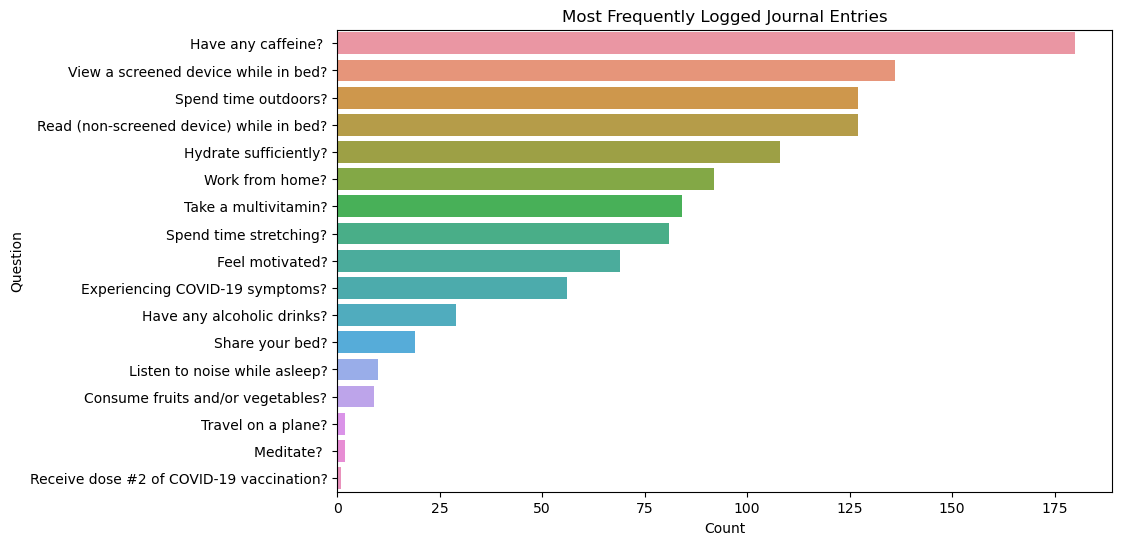

In [ ]:
journal_entries = jrn_df[jrn_df['Answered yes']==True]['Question text'].value_counts()
journal_entries = journal_entries.reset_index()
journal_entries.columns = ['Question', 'Count']
journal_entries = journal_entries.sort_values(by='Count', ascending=False)
journal_entries = journal_entries.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Question', data=journal_entries)
plt.title('Most Frequently Logged Journal Entries')
plt.show()

Processing the Journal Dataset so that each day is a single observation and only keeping the days where I completed the journal

In [ ]:
jrn_df.drop_duplicates(subset=['date', 'Question text'], keep='first', inplace=True)
jrn_df = jrn_df[jrn_df['Answered yes']==True]
jrn_df = pd.concat([jrn_df[['date', 'Cycle start time']], pd.get_dummies(jrn_df['Question text'])], axis=1)
jrn_df = jrn_df.groupby('Cycle start time').max()
jrn_df = jrn_df.set_index(pd.Series(jrn_df.index).dt.date, inplace=False)

Removing naps and joining journal, physiological, and sleep datasets

In [ ]:
sleep_df = sleep_df.groupby('Cycle start time').max()
sleep_df = sleep_df[sleep_df['Nap']==False]
sleep_df = sleep_df.set_index('date', inplace=False)
sleep_df.drop(['Nap', 'time', 'hour', 'weekday'], axis=1, inplace=True)

In [ ]:
phys_df = phys_df.groupby('date').max()
df = phys_df.join(jrn_df, how="left", rsuffix='jrn').join(sleep_df, how="left", rsuffix='slp')

# dropping duplicate columns carried over from join
to_drop = []
for col in df.columns:
    if 'slp' in col or 'jrn' in col:
        to_drop.append(col)
df.drop(to_drop, axis=1, inplace=True)

# stripping the column names of leading and trailing whitespace
for col in df.columns:
    col_stripped = col.strip()
    if col_stripped != col:
        df.rename(columns={col: col_stripped}, inplace=True)

df.columns

Index(['Cycle start time', 'Cycle end time', 'Cycle timezone',
       'Recovery score %', 'Resting heart rate (bpm)',
       'Heart rate variability (ms)', 'Skin temp (celsius)', 'Blood oxygen %',
       'Day Strain', 'Energy burned (cal)', 'Max HR (bpm)', 'Average HR (bpm)',
       'Sleep onset', 'Wake onset', 'Sleep performance %',
       'Respiratory rate (rpm)', 'Asleep duration (min)',
       'In bed duration (min)', 'Light sleep duration (min)',
       'Deep (SWS) duration (min)', 'REM duration (min)',
       'Awake duration (min)', 'Sleep need (min)', 'Sleep debt (min)',
       'Sleep efficiency %', 'time', 'hour', 'weekday', 'date',
       'Consume fruits and/or vegetables?', 'Engage in sexual activity?',
       'Experiencing COVID-19 symptoms?', 'Feel motivated?',
       'Have any alcoholic drinks?', 'Have any caffeine?',
       'Hydrate sufficiently?', 'Listen to noise while asleep?', 'Masturbate?',
       'Meditate?', 'Read (non-screened device) while in bed?',
       'Recei

Adding logged workouts to master dataset

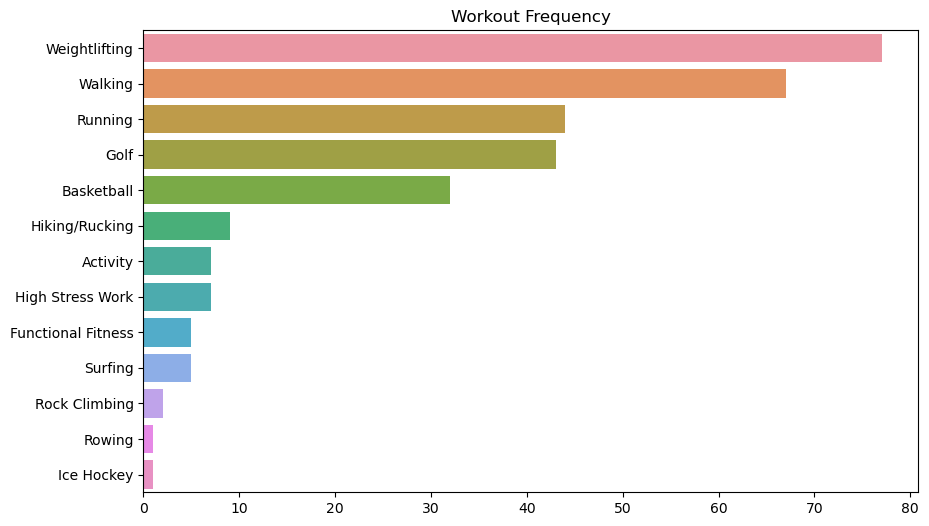

In [ ]:
wkt_frequency = wkt_df['Activity name'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=wkt_frequency.values, y=wkt_frequency.index, orient='h')
plt.title('Workout Frequency')
plt.show()

In [ ]:
print('Average Strain by Activity')
wkt_df[['Activity name', 'Activity Strain']].groupby('Activity name').mean().sort_values(by='Activity Strain', ascending=False)

Average Strain by Activity


,Activity Strain
Activity name,
Basketball,11.946875
Running,11.152273
Ice Hockey,11.000000
Hiking/Rucking,10.311111
Golf,9.423256
Functional Fitness,9.260000
Rock Climbing,7.950000
Weightlifting,7.629870
High Stress Work,7.485714


In [ ]:
wkt_df_num = wkt_df.drop(['time', 'hour', 'weekday', 'Cycle start time', 'Cycle end time', 
                          'Cycle timezone', 'Workout start time', 'Workout end time', 
                          'Activity name', 'GPS enabled'], axis=1, inplace=False)

wkt_df_num = wkt_df_num.groupby('date').sum()

In [ ]:
df = df.join(wkt_df_num, how='left', rsuffix='wkt')

In [ ]:
df.to_csv('whoop_data_merged.csv')

## Replicating Strain Scoring Algorithm

In [ ]:
X = df[['Energy burned (cal)', 'Max HR (bpm)', 'Average HR (bpm)', 'Duration (min)', 'Activity Strain', 'HR Zone 1 %', 'HR Zone 2 %',
       'HR Zone 3 %', 'HR Zone 4 %', 'HR Zone 5 %']]
y = df['Day Strain'] / 21

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=7, col_sample_bytree=0.8, subsample=0.8)
xgb.fit(X_train, y_train)

[11:58:31] WARNING: /Users/patrickgeitner/xgboost-1.4.2/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:573: 
Parameters: { "col_sample_bytree" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', col_sample_bytree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ', rmse)

RMSE:  0.028198591619677055


/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


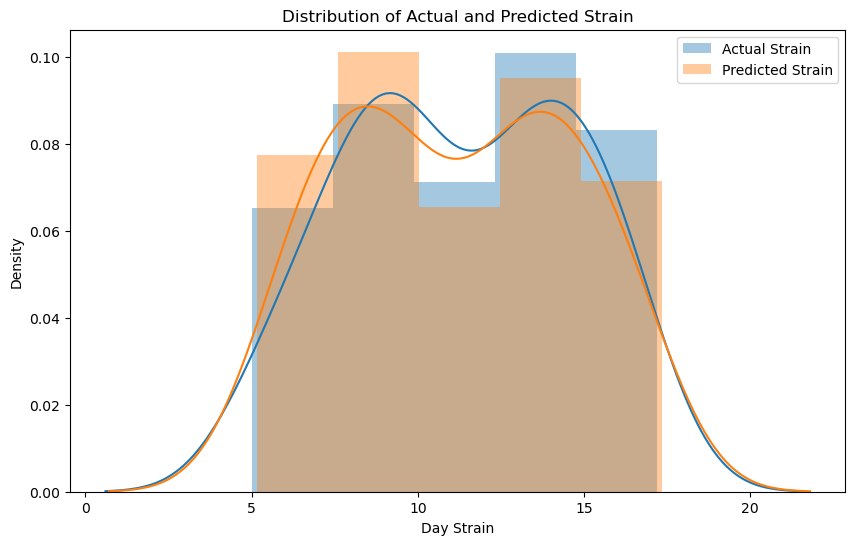

In [ ]:
# plotting distribution of actual and predicted strain
plt.figure(figsize=(10, 6))
sns.distplot(y_test * 21, label='Actual Strain')
sns.distplot(y_pred * 21, label='Predicted Strain')
plt.title('Distribution of Actual and Predicted Strain')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted Strain')

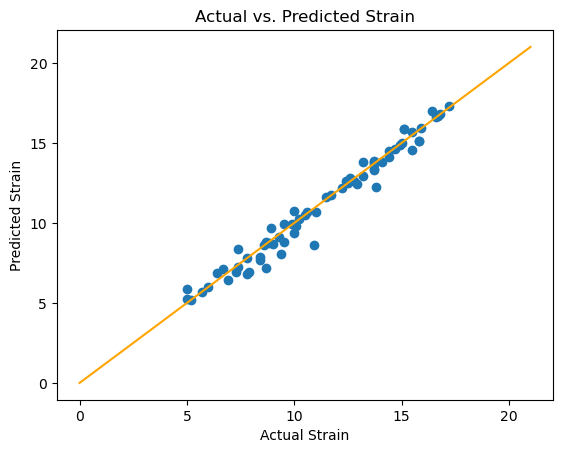

In [ ]:
plt.plot(y_test * 21, y_pred * 21, 'o')
plt.plot([0, 21], [0, 21], 'orange')
plt.xlabel('Actual Strain')
plt.ylabel('Predicted Strain')
plt.title('Actual vs. Predicted Strain')

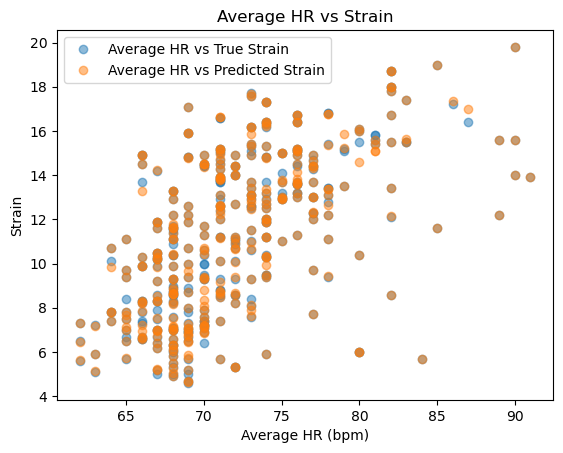

In [ ]:
plt.plot(df['Average HR (bpm)'], df['Day Strain'], 'o', alpha = 0.5, label='Average HR vs True Strain')
plt.plot(df['Average HR (bpm)'], xgb.predict(X) * 21, 'o', alpha = 0.5, label='Average HR vs Predicted Strain')
plt.xlabel('Average HR (bpm)')
plt.ylabel('Strain')
plt.title('Average HR vs Strain')
plt.legend()
plt.show()

## Replicating Recovery Scoring Algorithm

In [ ]:
X = df[['Resting heart rate (bpm)', 'Heart rate variability (ms)', 'Skin temp (celsius)', 
        'Blood oxygen %', 'Sleep performance %',
       'Respiratory rate (rpm)', 'Asleep duration (min)', 'Sleep efficiency %']]

y = df['Recovery score %'] / 100

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=4, col_sample_bytree=0.9, subsample=0.8)
xgb.fit(X_train, y_train)

/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[12:00:10] WARNING: /Users/patrickgeitner/xgboost-1.4.2/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:573: 
Parameters: { "col_sample_bytree" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', col_sample_bytree=0.9,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ', rmse)

RMSE:  0.09830534905013875


/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


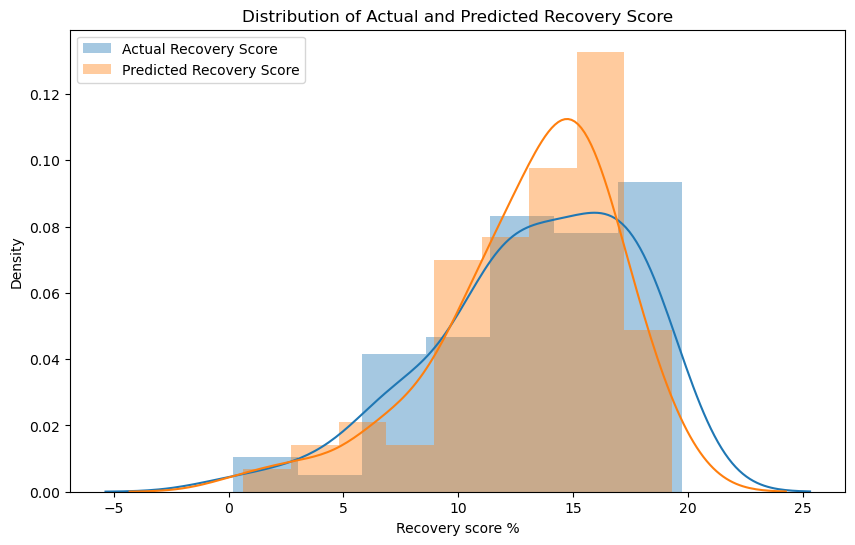

In [ ]:
plt.figure(figsize=(10, 6))
sns.distplot(y_test * 21, label='Actual Recovery Score')
sns.distplot(y_pred * 21, label='Predicted Recovery Score')
plt.title('Distribution of Actual and Predicted Recovery Score')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted Recovery Score')

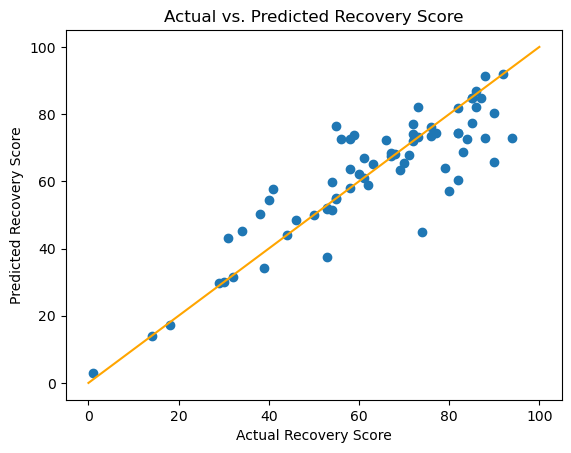

In [ ]:
plt.plot(y_test * 100, y_pred * 100, 'o')
plt.plot([0, 100], [0, 100], 'orange')
plt.xlabel('Actual Recovery Score')
plt.ylabel('Predicted Recovery Score')
plt.title('Actual vs. Predicted Recovery Score')

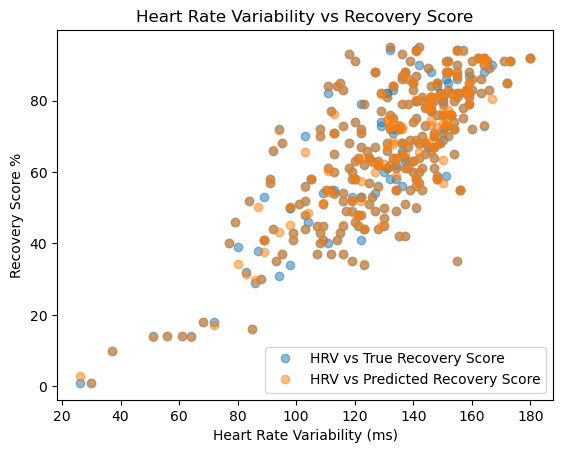

In [ ]:
plt.plot(df['Heart rate variability (ms)'], df['Recovery score %'], 'o', alpha = 0.5, label='HRV vs True Recovery Score')
plt.plot(df['Heart rate variability (ms)'], xgb.predict(X) * 100, 'o', alpha = 0.5, label='HRV vs Predicted Recovery Score')
plt.xlabel('Heart Rate Variability (ms)')
plt.ylabel('Recovery Score %')
plt.title('Heart Rate Variability vs Recovery Score')
plt.legend()
plt.show()